# Lasso

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import copy

import import_ipynb

from _Self_Written_Functions_Sheet import (conditions_edit, nbrhd_rank, drop_nbrhd,
totallivsf_add, drop_grlivarea, bsmtfin_add, drop_bsmtfinsf12, totalporchsf_add,
drop_porches, yrsremodtosold_add, drop_yrsoldremod, fireplace_yes, drop_fireplaces,
pool_yes, drop_poolarea, totalbaths_add, drop_baths, totalbsmtbaths_add,
drop_bsmtbaths)

from _Self_Written_Functions_Sheet import (dum_scale, use_og_data, comb_list_generator,
                                           apply_comb_list, rmse)

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [2]:
hp_train = pd.read_csv('..\hp_2a_ranked_edited_train.csv', index_col=0)
hp_test = pd.read_csv('..\hp_2a_ranked_edited_test.csv', index_col=0)
hp_logsp = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_saleprice = pd.read_csv('..\hp_1a_no_imputation_saleprice.csv', index_col=0)

# saving train index
hp_index = hp_train.index

combo_nonedit = pd.concat([hp_train, hp_test])
combo_nonedit.columns = hp_train.columns

# convert all possible numeric types to numeric
for col in combo_nonedit.columns: 
    combo_nonedit[col] = combo_nonedit[col].astype('float', errors='ignore')

combo_cols = list(combo_nonedit.columns)

combo = copy.deepcopy(combo_nonedit)

combo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Feb,2008.0,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,May,2007.0,WD,Normal
2,2-STORY 1946 & NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Sep,2008.0,WD,Normal
3,2-STORY 1945 & OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Feb,2006.0,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Dec,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2-STORY PUD - 1946 & NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Jun,2006.0,WD,Normal
2913,2-STORY PUD - 1946 & NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.

In [3]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
lasso_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
lasso_feat_eng = [nbrhd_rank, totallivsf_add, totalporchsf_add, fireplace_yes, conditions_edit,
                  drop_grlivarea, drop_bsmtfinsf12, drop_fireplaces, drop_baths, drop_bsmtbaths]

for feat in lasso_feat_eng:
    feat(lasso_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(lasso_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_full_strd_to_use

,Fireplace,TotalPorchSF,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,YrSold,NbMedianRank,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.050539,0.237373,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.883333,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.166667,0.064212,0.168008,1.00,1.0,1.00,0.109641,0.413559,0.0,0.375,0.333333,0.66

In [4]:
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Trying with Lasso

In [5]:
state = 0
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

lasso = Lasso(random_state=state, max_iter=1000000, selection='random')

# parameters to use
alphas = np.linspace(1e-4, 20, 30)
fitintercept = [True, False]
warmstart = [True, False]

gparam_lasso_1 = {'alpha': alphas,
                  'fit_intercept': fitintercept,
                  'warm_start': warmstart}

# setting parameters
gs_lasso_1 = ms.GridSearchCV(lasso, gparam_lasso_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_lasso_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_lasso_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_lasso_1, ytrain, xtrain))
test_rmse.append(rmse(gs_lasso_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_lasso_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
lasso_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
lasso_res_df = pd.DataFrame(lasso_list_results).T
lasso_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
lasso_res_df = pd.concat([lasso_res_df, best_par_df], axis=1, sort=False)

lasso_res_df

Wall time: 2.99 s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,fit_intercept,warm_start
0,0.93972,0.937727,0.097313,0.102731,-0.005418,0.0001,True,True


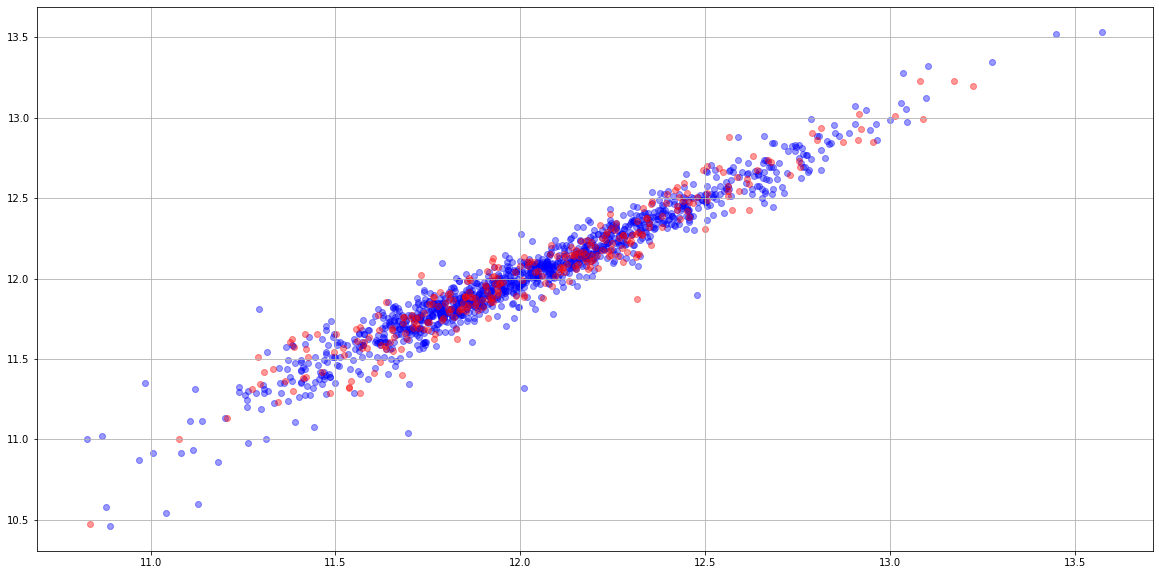

In [6]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_lasso_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_lasso_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

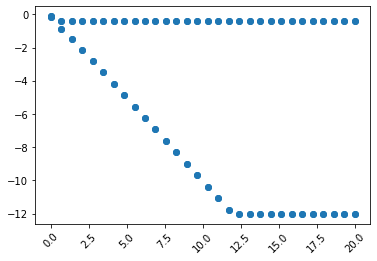

In [7]:
plt.xticks(rotation=45)
plt.scatter(gs_lasso_1.cv_results_['param_alpha'], gs_lasso_1.cv_results_['mean_test_score'])

In [8]:
state = 0
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

lasso = Lasso(random_state=state, max_iter=1000000, selection='random')

# parameters to use
alphas = np.linspace(3e-4, 5e-4, 801)
fitintercept = [True, False]
warmstart = [True, False]

gparam_lasso_1 = {'alpha': alphas,
                  'fit_intercept': fitintercept,
                  'warm_start': warmstart}

# setting parameters
gs_lasso_1 = ms.GridSearchCV(lasso, gparam_lasso_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_lasso_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_lasso_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_lasso_1, ytrain, xtrain))
test_rmse.append(rmse(gs_lasso_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_lasso_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
lasso_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
lasso_res_df = pd.DataFrame(lasso_list_results).T
lasso_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
lasso_res_df = pd.concat([lasso_res_df, best_par_df], axis=1, sort=False)

lasso_res_df

Wall time: 3min 6s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,fit_intercept,warm_start
0,0.92971,0.934331,0.105083,0.105495,-0.000412,0.000406,True,True


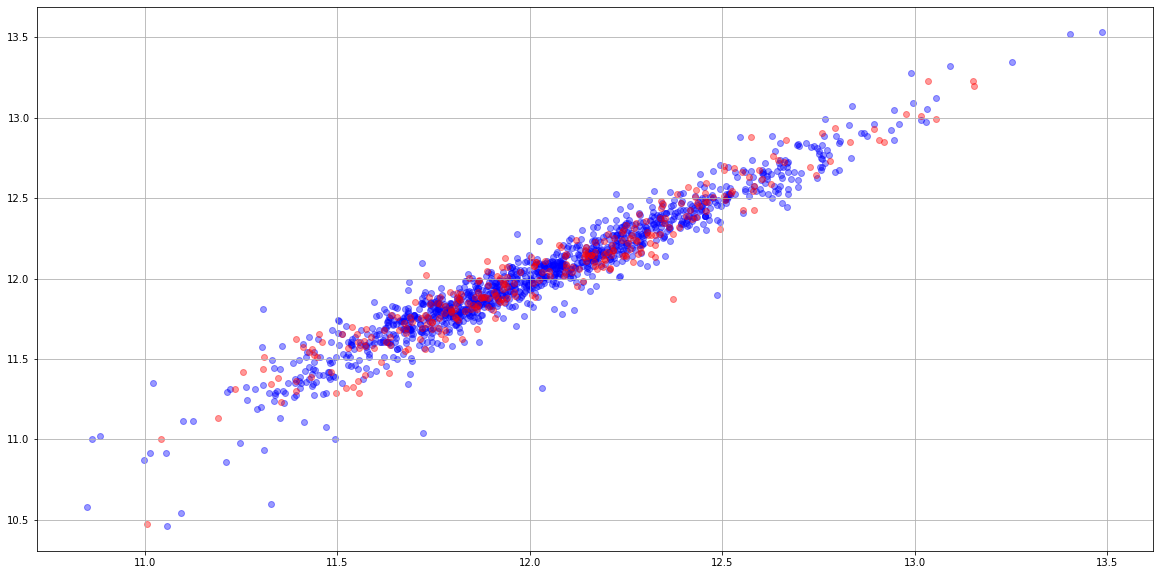

In [9]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_lasso_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_lasso_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

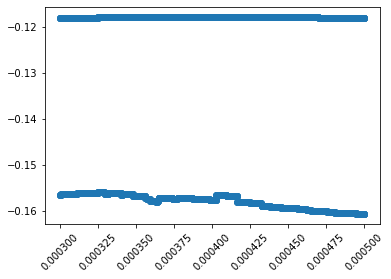

In [10]:
plt.xticks(rotation=45)
plt.scatter(gs_lasso_1.cv_results_['param_alpha'], gs_lasso_1.cv_results_['mean_test_score'])

# USING LINEAR MODEL DATASET

In [11]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
lasso_df_lm = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
lasso_feat_eng_lm = [totalporchsf_add, yrsremodtosold_add, fireplace_yes, pool_yes, 
                     totalbsmtbaths_add, conditions_edit, drop_grlivarea, drop_porches, 
                     drop_yrsoldremod, drop_fireplaces, drop_baths, drop_bsmtbaths]


for feat in lasso_feat_eng_lm:
    feat(lasso_df_lm)
    
# dummify and scale the dataset
hp_lm = copy.deepcopy(dum_scale(lasso_df_lm))

hp_lm = copy.deepcopy(hp_lm.loc[hp_index])

hp_lm

,TotalBsmtBaths,Pool,Fireplace,YrsRemodToSold,TotalPorchSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscVal,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.333333,0.0,0.0,0.083333,0.050539,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.176060,0.166667,0.000000,0.064212,0.168008,1.00,1.0,1.00,0.109641,0.413559,0.0,0.375,0.333333,0.666667,0.461538

In [12]:
state = 0

# setting up train and test sets
xtrain_lm, xtest_lm, ytrain_lm, ytest_lm = ms.train_test_split(hp_lm,
                                                               hp_logsp,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_lm = ytrain_lm.values.flatten()

In [13]:
state = 0
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

lasso = Lasso(random_state=state, max_iter=1000000, selection='random')

# parameters to use
alphas = np.linspace(2e-4, 6e-4, 801)
fitintercept = [True, False]
warmstart = [True, False]

gparam_lasso_lm = {'alpha': alphas,
                  'fit_intercept': fitintercept,
                  'warm_start': warmstart}

# setting parameters
gs_lasso_lm = ms.GridSearchCV(lasso, gparam_lasso_lm, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso_lm.fit(xtrain_lm, ytrain_lm)

# setting up dataframe for results
train_scores.append(gs_lasso_lm.best_estimator_.score(xtrain_lm, ytrain_lm))
test_scores.append(gs_lasso_lm.best_estimator_.score(xtest_lm, ytest_lm))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_lasso_lm, ytrain_lm, xtrain_lm))
test_rmse.append(rmse(gs_lasso_lm, ytest_lm, xtest_lm))

# add the best parameters to the df
best_par_list.append(gs_lasso_lm.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
lasso_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
lasso_res_df = pd.DataFrame(lasso_list_results).T
lasso_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
lasso_res_df = pd.concat([lasso_res_df, best_par_df], axis=1, sort=False)

lasso_res_df

Wall time: 3min 20s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,fit_intercept,warm_start
0,0.928834,0.932075,0.105736,0.107292,-0.001556,0.000427,True,True


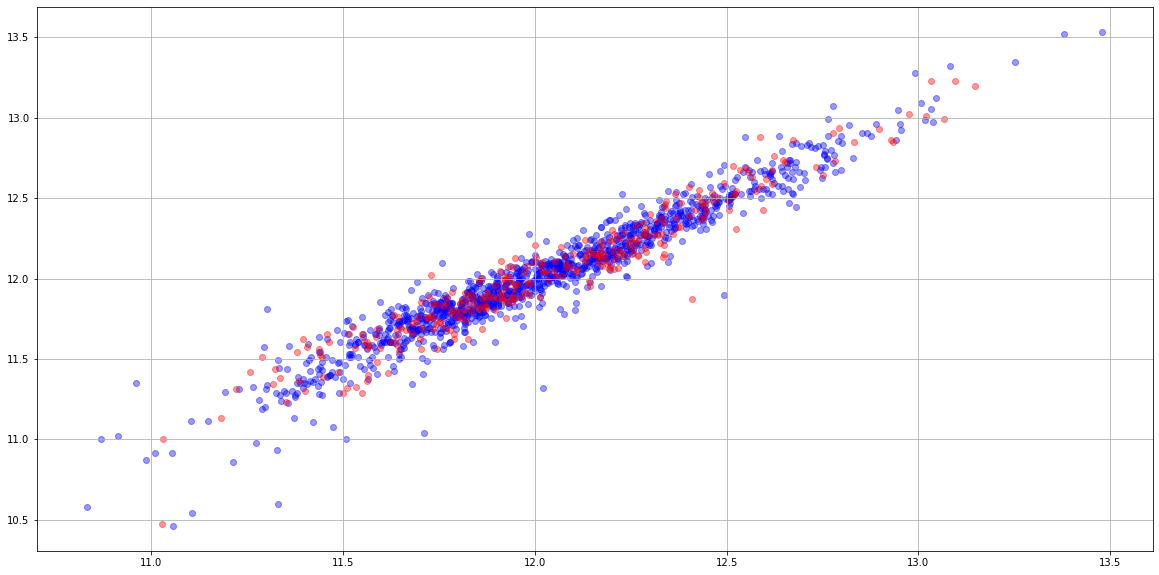

In [14]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_lasso_lm.best_estimator_.predict(xtrain_lm), ytrain_lm, color='blue', alpha=0.4)
plt.scatter(gs_lasso_lm.best_estimator_.predict(xtest_lm), ytest_lm, color='red', alpha=0.4)
plt.grid(which='both')

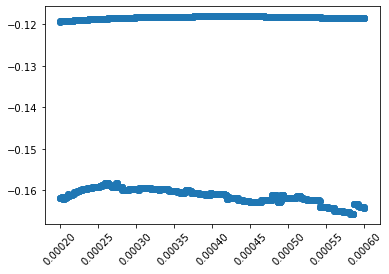

In [15]:
plt.xticks(rotation=45)
plt.scatter(gs_lasso_lm.cv_results_['param_alpha'], gs_lasso_lm.cv_results_['mean_test_score'])

# Using Lasso Reduced Dataset with Linear Regression

In [16]:
# Most important features
lasso_coef_strd = pd.Series(gs_lasso_1.best_estimator_.coef_, index=hp_full_strd_to_use.columns)
print(lasso_coef_strd.abs().sort_values(ascending=False).to_string())

TotalLivSF                                                          1.260682
1stFlrSF                                                            0.500753
OverallQual                                                         0.490762
OverallCond                                                         0.258224
2ndFlrSF                                                            0.233251
LotArea                                                             0.203301
YearBuilt                                                           0.161443
Functional                                                          0.157840
BsmtUnfSF                                                           0.149923
GarageCars                                                          0.143306
SaleCondition_Partial                                               0.121626
MSZoning_FV                                                         0.102667
Neighborhood_Crawfor                                                0.097745

In [17]:
# Getting df with most important features only
lasso_coef_index_01 = [i for i, x in enumerate(lasso_coef_strd) if abs(x) > 0]

hp_lasso_strd_reduced = hp_full_strd.iloc[:,lasso_coef_index_01]

# hp_lasso_strd_reduced.to_csv('..\hp_lasso_strd_reduced.csv')
hp_lasso_strd_reduced

,Fireplace,TotalPorchSF,TotalLivSF,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,KitchenQual,TotRmsAbvGrd,Functional,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,ScreenPorch,Fence,YrSold,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSZoning_FV,MSZoning_RH,MSZoning_RL,LotShape_IR2,LotShape_Reg,LandContour_HLS,LotConfig_CulDSac,LotConfig_Inside,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,BldgType_2fmCon,BldgType_TwnhsE,BldgType_TwnhsI,RoofStyle_Gable,RoofStyle_Gambrel,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_PConc,Heating_GasW,Heating_Grav,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,MoSold_Feb,MoSold_Jun,MoSold_May,MoSold_Nov,MoSold_Sep,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.050539,0.237373,0.150685,0.033420,1.0,0.666667,0.500,0.949275,0.883333,0.12250,0.666667,0.8,0.25,1.000000,0.166667,0.064212,1.00,1.0,0.109641,0.413559,0.666667,0.461538,1.0,0.666667,0.4,0.368280,0.6,0.6,1.0,0.000000,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.000000,0.217307,0.202055,0.038795,1.0,0.555556,0.875,0.753623,0.433333,0.00000,0.333333,0.8,1.00,0.833333,0.166667,0.121575,1.00,1.0,0.194917,0.000000,0.333333,0.307692,1.0,0.666667,0.4,0.309140,0.6,0.6,1.0,0.209270,0.0,0.0,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.034797,0.220955,0.160959,0.046507,1.0,0.666667,0.500,0.934783,0.866667,0.10125,0.666667,0.8,0.50,1.000000,0.166667,0.185788,1.00,1.0,0.123083,0.419370,0.666667,0.307692,1.0,0.666667,0.4,0.408602,0.6,0.6,1.0,0.000000,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.254350,0.182305,0.133562,0.038561,1.0,0.666667,0.500,0.311594,0.333333,0.00000,0.333333,0.6,0.25,0.833333,0.166667,0.231164,0.75,1.0,0.131695,0.366102,0.666667,0.384615,1.0,0.333333,0.6,0.431452,0.6,0.6,1.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.069594,0.287196,0.215753,0.060576,1.0,0.777778,0.500,0.927536,0.833333,0.21875,0.666667,0.8,0.75,1.000000,0.166667,0.209760,1.00,1.0,0.170342,0.509927,0.666667,0.538462,1.0,0.666667,0.6,0.561828,0.6,0.6,1.0,0.134831,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## features that were kept with lasso

In [18]:
# columns that were dropped by lasso

lasso_coef_index_00 = [i for i, x in enumerate(lasso_coef_strd) if abs(x) == 0]
hp_lasso_strd_dropped = hp_full_strd.iloc[:, lasso_coef_index_00]

hp_lasso_strd_dropped_rdc = copy.deepcopy(hp_lasso_strd_dropped.iloc[hp_index])

hp_lasso_strd_dropped_rdc

,Alley,Utilities,ExterCond,BsmtCond,TotalBsmtSF,Electrical,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,GarageYrBlt,OpenPorchSF,EnclosedPorch,3SsnPorch,PoolArea,PoolQC,MiscVal,NbMedianRank,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_RM,LotShape_IR3,LandContour_Low,LandContour_Lvl,LotConfig_FR2,LotConfig_FR3,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_Gilbert,Neighborhood_NPkVill,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_Duplex,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_VinylSd,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_VinylSd,Foundation_CBlock,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_TA,GarageType_CarPort,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Jan,MoSold_Jul,MoSold_Mar,MoSold_Oct,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Family
0,0.0,1.0,0.50,0.75,0.168008,1.00,0.0,0.375,0.333333,0.996517,0.082210,0.000000,0.0,0.0,0.0,0.000000,0.458333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.50,0.75,0.247694,1.00,0.0,0.375,0.333333,0.983085,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.50,0.75,0.180569,1.00,0.0,0.375,0.333333,0.995522,0.056604,0.000000,0.0,0.0,0.0,0.000000,0.458333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.50,1.00,0.148381,1.00,0.0,0.375,0.333333,0.994030,0.047170,0.268775,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## using the lasso reduced dataset in multilinear regression

In [19]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# setting up train_lso and test_lso sets
xtrain_lso, xtest_lso, ytrain_lso, ytest_lso = ms.train_test_split(hp_lasso_strd_dropped_rdc,
                                                                   hp_logsp,
                                                                   test_size=0.2,
                                                                   random_state=0)

# Must flatten to fit
ytrain_lso = ytrain_lso.values.flatten()

lm = LinearRegression()

# parameters to use
fitintercept = [True, False]
gparam_mlr = {'fit_intercept': fitintercept}

# setting parameters
gs_mlr = ms.GridSearchCV(lm, gparam_mlr, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_mlr.fit(xtrain_lso, ytrain_lso)

# setting up dataframe for results
train_scores.append(gs_mlr.best_estimator_.score(xtrain_lso, ytrain_lso))
test_scores.append(gs_mlr.best_estimator_.score(xtest_lso, ytest_lso))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_mlr, ytrain_lso, xtrain_lso))
test_rmse.append(rmse(gs_mlr, ytest_lso, xtest_lso))

# add the best parameters to the df
best_par_list.append(gs_mlr.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
lm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
lm_res_df = pd.DataFrame(lm_list_results).T
lm_res_df.columns = ['TrainScores', 'TestScores', 'train_rmse', 'test_rmse', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
lm_res_df_sel2 = pd.concat([lm_res_df, best_par_df], axis=1, sort=False)

lm_res_df_sel2

Wall time: 140 ms


,TrainScores,TestScores,train_rmse,test_rmse,DiffRMSE,fit_intercept
0,0.789633,0.518098,0.181792,0.28578,-0.103988,False


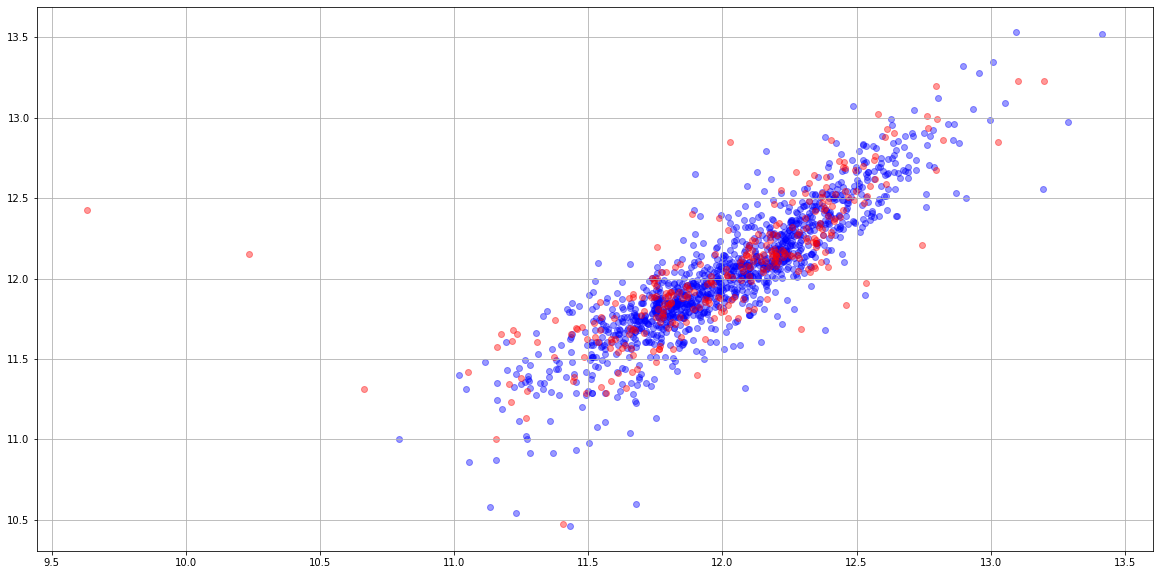

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_mlr.best_estimator_.predict(xtrain_lso), ytrain_lso, color='blue', alpha=0.4)
plt.scatter(gs_mlr.best_estimator_.predict(xtest_lso), ytest_lso, color='red', alpha=0.4)
plt.grid(which='both')

In [24]:
# Most important features
lasso_coef_strd = pd.Series(gs_lasso_1.best_estimator_.coef_, index=hp_full_strd_to_use.columns)

# Getting df with most important features only
lasso_coef_index_01 = [i for i, x in enumerate(lasso_coef_strd) if abs(x) > 0]

hp_lasso_strd_reduced = hp_full_strd.iloc[:,lasso_coef_index_01]

# columns that were dropped by lasso

lasso_coef_index_00 = [i for i, x in enumerate(lasso_coef_strd) if abs(x) == 0]
hp_lasso_strd_dropped = hp_full_strd.iloc[:, lasso_coef_index_00]

hp_lasso_strd_dropped_rdc = copy.deepcopy(hp_lasso_strd_dropped.iloc[hp_index])

hp_lasso_strd_dropped_rdc

,Alley,Utilities,ExterCond,BsmtCond,TotalBsmtSF,Electrical,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,GarageYrBlt,OpenPorchSF,EnclosedPorch,3SsnPorch,PoolArea,PoolQC,MiscVal,NbMedianRank,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_RM,LotShape_IR3,LandContour_Low,LandContour_Lvl,LotConfig_FR2,LotConfig_FR3,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_Gilbert,Neighborhood_NPkVill,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_Duplex,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_VinylSd,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_VinylSd,Foundation_CBlock,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_TA,GarageType_CarPort,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Jan,MoSold_Jul,MoSold_Mar,MoSold_Oct,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Family
0,0.0,1.0,0.50,0.75,0.168008,1.00,0.0,0.375,0.333333,0.996517,0.082210,0.000000,0.0,0.0,0.0,0.000000,0.458333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.50,0.75,0.247694,1.00,0.0,0.375,0.333333,0.983085,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.50,0.75,0.180569,1.00,0.0,0.375,0.333333,0.995522,0.056604,0.000000,0.0,0.0,0.0,0.000000,0.458333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.50,1.00,0.148381,1.00,0.0,0.375,0.333333,0.994030,0.047170,0.268775,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# BEST PARAM

In [ ]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
lasso_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
lasso_feat_eng = [nbrhd_rank, totallivsf_add, totalporchsf_add, fireplace_yes, conditions_edit,
                  drop_grlivarea, drop_bsmtfinsf12, drop_fireplaces, drop_baths, drop_bsmtbaths]

for feat in lasso_feat_eng:
    feat(lasso_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(lasso_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

lasso = Lasso(random_state=state, max_iter=1000000, selection='random')

# parameters to use
alphas = [0.000406]
fitintercept = [True]
warmstart = [True]

gparam_lasso_1 = {'alpha': alphas,
                  'fit_intercept': fitintercept,
                  'warm_start': warmstart}

# setting parameters
gs_lasso_1 = ms.GridSearchCV(lasso, gparam_lasso_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso_1.fit(xtrain, ytrain)